In [789]:
import pandas as pd
import numpy as np

In [790]:
df=pd.read_csv(r"C:\Users\hp\IDA_Stock_project\data_set_ida\main_data\.ipynb_checkpoints\cleaned_stock_data_updated-checkpoint.csv")

In [791]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43196 entries, 0 to 43195
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  43196 non-null  int64  
 1   Date        43196 non-null  object 
 2   Adj Close   43196 non-null  float64
 3   Close       43196 non-null  float64
 4   High        43196 non-null  float64
 5   Low         43196 non-null  float64
 6   Open        43196 non-null  float64
 7   Volume      43196 non-null  int64  
 8   Company     43196 non-null  object 
dtypes: float64(5), int64(2), object(2)
memory usage: 3.0+ MB


In [792]:
df

,Unnamed: 0,Date,Adj Close,Close,High,Low,Open,Volume,Company
0,0,2020-01-02,45.021324,45.810001,45.869999,44.520000,44.779999,625100,ACA
1,1,2020-01-03,44.913216,45.700001,45.980000,45.130001,45.540001,317200,ACA
2,2,2020-01-06,44.677349,45.459999,45.610001,45.119999,45.259998,241400,ACA
3,3,2020-01-07,44.274406,45.049999,45.619999,44.709999,45.279999,199700,ACA
4,4,2020-01-08,44.824780,45.610001,45.740002,44.990002,45.020000,459300,ACA
...,...,...,...,...,...,...,...,...,...
43191,43191,2024-11-25,291.225006,291.225006,293.774994,286.950012,287.750000,23297474,WIPRO.NS
43192,43192,2024-11-26,294.500000,294.500000,295.174988,289.649994,292.500000,15771340,WIPRO.NS
43193,43193,2024-11-27,291.450012,291.450012,298.000000,290.950012,295.750000,13659676,WIPRO.NS
43194,43194,2024-11-28,286.100006,286.100006,293.000000,285.274994,292.875000,11896556,WIPRO.NS


In [793]:

df['Date'] = pd.to_datetime(df['Date'])


In [794]:

start_date = '2024-05-29'
end_date = '2024-11-29'

# Filter the data

df = df[(df['Date'] < start_date)]    #training
final_test_data= df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]    #TEST


In [795]:
del df['Unnamed: 0']


In [796]:
df=df.copy()
df['Target'] = (df['Adj Close'].shift(-30) > df['Adj Close']).astype(int)
df['Target'].value_counts()

Target
1    22760
0    15924
Name: count, dtype: int64

**NEED PLOT HERE COUNT**

In [798]:
# Price-based Features
# Daily Returns:
# Calculate percentage change in Adj Close prices.
df['Daily_Return'] = df['Adj Close'].pct_change()


grouped = df.groupby('Company')

# Add Moving Average, Upper, and Lower Boundaries
window_size=14
std_multiplier=2
df['Moving Average'] = grouped['Close'].transform(lambda x: x.rolling(window=window_size).mean())
df['Rolling Std'] = grouped['Close'].transform(lambda x: x.rolling(window=window_size).std())
df['Upper Boundary'] = df['Moving Average'] + (std_multiplier * df['Rolling Std'])
df['Lower Boundary'] = df['Moving Average'] - (std_multiplier * df['Rolling Std'])
df['Log Return'] = np.log(df['Close'] / df['Close'].shift(1))
df['Moving Average Log Return'] = grouped['Log Return'].transform(lambda x: x.rolling(window=window_size).mean())
df['EMA_30'] = grouped['Close'].transform(lambda x: x.ewm(span=30, adjust=False).mean())


#  Price-based Features
# Daily Returns:
# Calculate percentage change in Adj Close price

# Rolling Statistics:
# Compute rolling mean, standard deviation, and volatility over different windows (e.g., 7, 14, 30 days)


df['Rolling_Mean_7'] = df['Adj Close'].rolling(window=7).mean()
df['Rolling_Std_7'] = df['Adj Close'].rolling(window=7).std()
df['Rolling_Mean_14'] = df['Adj Close'].rolling(window=14).mean()
df['Rolling_Std_14'] = df['Adj Close'].rolling(window=14).std()
df['Rolling_Mean_30'] = df['Adj Close'].rolling(window=30).mean()
df['Rolling_Std_30'] = df['Adj Close'].rolling(window=30).std()


# Momentum Indicators:
# Example: Relative Strength Index (RSI)
def compute_rsi(data, window=14):
    delta = data.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = compute_rsi(df['Adj Close'])

# Volume-based Features
# Volume Rolling Stats:
# Rolling mean and standard deviation of volume.

df['Volume_Rolling_Mean_7'] = df['Volume'].rolling(window=7).mean()
df['Volume_Rolling_Std_7'] = df['Volume'].rolling(window=7).std()

df['Volume_Rolling_Mean_14'] = df['Volume'].rolling(window=14).mean()
df['Volume_Rolling_Std_14'] = df['Volume'].rolling(window=14).std()

df['Volume_Rolling_Mean_30'] = df['Volume'].rolling(window=30).mean()
df['Volume_Rolling_Std_30'] = df['Volume'].rolling(window=30).std()

# Lagged Features
# Include lagged values of Adj Close and Volume to capture short-term trends.

for lag in [1, 2,3, 5,7, 10,14]:
    df[f'Lag_{lag}'] = df['Adj Close'].shift(lag)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Company_Encoded'] = le.fit_transform(df['Company'])


# Moving Average Convergence Divergence (MACD)
# Purpose: Tracks the relationship between two moving averages of a stock's price.

df['EMA_12'] = df['Adj Close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['Adj Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA_12'] - df['EMA_26']
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

df['14_high'] = df['High'].rolling(window=14).max()
df['14_low'] = df['Low'].rolling(window=14).min()
df['7_high'] = df['High'].rolling(window=7).max()
df['7_low'] = df['Low'].rolling(window=7).min()
df['2_high'] = df['High'].rolling(window=2).max()
df['2_low'] = df['Low'].rolling(window=2).min()


df['%K'] = (df['Close'] - df['14_low']) / (df['14_high'] - df['14_low']) * 100
df['%D'] = df['%K'].rolling(window=3).mean()

df['%R'] = (df['14_high'] - df['Close']) / (df['14_high'] - df['14_low']) * -100



df['ROC'] = df['Adj Close'].pct_change(periods=10) * 100


df['TR'] = df[['High', 'Low', 'Close']].apply(
    lambda x: max(x['High'] - x['Low'], abs(x['High'] - x['Close']), abs(x['Low'] - x['Close'])), axis=1)
df['ATR'] = df['TR'].rolling(window=14).mean()


df['Typical_Price'] = (df['High'] + df['Low'] + df['Close']) / 3
df['CCI'] = (df['Typical_Price'] - df['Typical_Price'].rolling(window=20).mean()) / (0.015 * df['Typical_Price'].rolling(window=20).std())


df['MA_7'] = df['Close'].rolling(window=7).mean()
df['MA_14'] = df['Close'].rolling(window=14).mean()
df['MA_30'] = df['Close'].rolling(window=30).mean()


df['Disparity_7'] = (df['Close'] / df['MA_7'] - 1) * 100
df['Disparity_14'] = (df['Close'] / df['MA_14'] - 1) * 100
df['Disparity_30'] = (df['Close'] / df['MA_30'] - 1) * 100



df = df.copy()

# df['Company_ID'] = df['Company'].astype('category').cat.codes

if 'Date' in df.columns:
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek  # Optional: Add the day of the week as a feature
    df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)  # Optional: Feature for weekends (1 if weekend, 0 otherwise)
    df.drop(columns=['Date'], inplace=True)  # Drop the original 'Date' column




#RSI IS .4% MI, AND IT TAKES ABOUT 1000+ ROWS AS NULL SO IM REMOVING
# similarly %K,D,R
del df['RSI']
del df['%K']
del df['%D']
del df['%R']

In [799]:
df

,Adj Close,Close,High,Low,Open,Volume,Company,Target,Daily_Return,Moving Average,...,MA_14,MA_30,Disparity_7,Disparity_14,Disparity_30,Year,Month,Day,DayOfWeek,IsWeekend
0,45.021324,45.810001,45.869999,44.520000,44.779999,625100,ACA,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2020,1,2,3,0
1,44.913216,45.700001,45.980000,45.130001,45.540001,317200,ACA,1,-0.002401,NaN,...,NaN,NaN,NaN,NaN,NaN,2020,1,3,4,0
2,44.677349,45.459999,45.610001,45.119999,45.259998,241400,ACA,0,-0.005252,NaN,...,NaN,NaN,NaN,NaN,NaN,2020,1,6,0,0
3,44.274406,45.049999,45.619999,44.709999,45.279999,199700,ACA,1,-0.009019,NaN,...,NaN,NaN,NaN,NaN,NaN,2020,1,7,1,0
4,44.824780,45.610001,45.740002,44.990002,45.020000,459300,ACA,0,0.012431,NaN,...,NaN,NaN,NaN,NaN,NaN,2020,1,8,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43064,230.649994,230.649994,231.725006,229.425003,231.449997,7765884,WIPRO.NS,0,0.000868,229.375000,...,229.375000,230.850833,0.462002,0.555856,-0.087000,2024,5,22,2,0
43065,232.899994,232.899994,234.000000,230.875000,231.250000,13171332,WIPRO.NS,0,0.009755,229.675000,...,229.675000,230.530000,1.006782,1.404155,1.028063,2024,5,23,3,0
43066,231.824997,231.824997,235.250000,231.000000,233.500000,8205526,WIPRO.NS,0,-0.004616,229.899999,...,229.899999,230.259166,0.313717,0.837320,0.680030,2024,5,24,4,0
43067,226.225006,226.225006,231.074997,225.800003,231.000000,40983758,WIPRO.NS,0,-0.024156,229.678571,...,229.678571,229.870000,-1.932155,-1.503652,-1.585676,2024,5,27,0,0


In [800]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38684 entries, 0 to 43068
Data columns (total 62 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Adj Close                  38684 non-null  float64
 1   Close                      38684 non-null  float64
 2   High                       38684 non-null  float64
 3   Low                        38684 non-null  float64
 4   Open                       38684 non-null  float64
 5   Volume                     38684 non-null  int64  
 6   Company                    38684 non-null  object 
 7   Target                     38684 non-null  int32  
 8   Daily_Return               38683 non-null  float64
 9   Moving Average             38164 non-null  float64
 10  Rolling Std                38164 non-null  float64
 11  Upper Boundary             38164 non-null  float64
 12  Lower Boundary             38164 non-null  float64
 13  Log Return                 38683 non-null  float64


<Axes: >

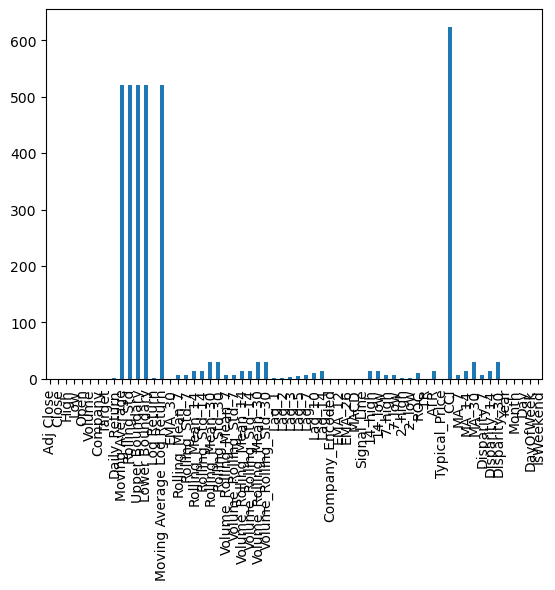

In [801]:
df.isnull().sum().plot(kind='bar')

# MUTUAL INFORMATION

In [803]:
 df=df.dropna()

In [804]:

X = df.drop(columns=['Target', 'Company'])
y = df['Target']

In [805]:
from sklearn.feature_selection import mutual_info_classif
import pandas as pd

# Calculate Mutual Information
mi_scores = mutual_info_classif(X, y, discrete_features=False)


In [806]:

# Create a DataFrame for better visualization
mi_df = pd.DataFrame({
    'Feature': X.columns,
    'Mutual Information': mi_scores
}).sort_values(by='Mutual Information', ascending=False)


In [807]:

# Display top features by MI
mi_df


,Feature,Mutual Information
38,14_high,0.308336
39,14_low,0.304943
40,7_high,0.276974
41,7_low,0.276752
42,2_high,0.095582
43,2_low,0.094118
9,Upper Boundary,0.061408
10,Lower Boundary,0.056520
13,EMA_30,0.052803
35,EMA_26,0.051398


In [808]:
threshold = 0.02  


# Filter features by mutual information
selected_features = mi_df[mi_df['Mutual Information'] >= threshold]['Feature'].tolist()
X = df[selected_features]
X


,14_high,14_low,7_high,7_low,2_high,2_low,Upper Boundary,Lower Boundary,EMA_30,EMA_26,...,Volume_Rolling_Std_30,High,Low,Lag_7,Lag_14,Open,Lag_10,Volume_Rolling_Mean_14,Volume_Rolling_Mean_30,Volume_Rolling_Std_14
29,47.849998,43.689999,47.849998,44.872002,47.849998,46.084999,47.718759,43.115527,45.724219,44.992269,...,1.073491e+05,47.849998,46.779999,43.909481,44.047226,46.919998,44.086586,2.710643e+05,2.889700e+05,1.010826e+05
30,47.849998,43.689999,47.849998,44.872002,47.849998,46.740002,47.974821,43.215179,45.805882,45.084056,...,8.682233e+04,47.730000,46.740002,45.906712,43.781590,47.730000,43.043694,2.596214e+05,2.761600e+05,9.406609e+04
31,47.849998,43.689999,47.849998,44.872002,47.730000,46.330002,48.130237,43.274049,45.860341,45.144265,...,8.948996e+04,47.160000,46.330002,44.991726,44.421093,46.830002,43.171604,2.472571e+05,2.705400e+05,9.662033e+04
32,47.849998,43.689999,47.849998,44.560001,47.160000,44.560001,48.130237,43.274049,45.789352,45.062274,...,9.164171e+04,46.820000,44.560001,44.509647,44.037380,46.820000,43.909481,2.502286e+05,2.752867e+05,1.003331e+05
33,47.849998,43.689999,47.849998,44.560001,46.820000,44.560001,48.133489,43.383654,45.777135,45.047574,...,9.055700e+04,46.099998,44.570000,45.168827,44.086586,44.639999,45.906712,2.580929e+05,2.783467e+05,9.882682e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43064,233.750000,222.500000,233.750000,222.500000,232.399994,229.425003,233.362768,225.387232,232.549610,231.814619,...,5.925713e+06,231.725006,229.425003,225.925003,231.199997,231.449997,231.949997,8.536036e+06,1.176435e+07,3.029072e+06
43065,234.000000,222.500000,234.000000,226.100006,234.000000,229.425003,234.056514,225.293485,232.572216,231.895017,...,5.843190e+06,234.000000,230.875000,225.975006,228.699997,231.250000,231.600006,8.409898e+06,1.198959e+07,2.767476e+06
43066,235.250000,222.500000,235.250000,227.324997,235.250000,230.875000,234.382655,225.417343,232.524008,231.889830,...,5.181122e+06,235.250000,231.000000,228.175003,228.675003,233.500000,227.949997,8.300962e+06,1.137508e+07,2.741382e+06
43067,235.250000,222.500000,235.250000,225.800003,235.250000,225.800003,234.571099,224.786044,232.117621,231.470214,...,7.461212e+06,231.074997,225.800003,229.149994,229.324997,231.000000,225.925003,1.073422e+07,1.221450e+07,9.119125e+06


In [809]:
X.columns

Index(['14_high', '14_low', '7_high', '7_low', '2_high', '2_low',
       'Upper Boundary', 'Lower Boundary', 'EMA_30', 'EMA_26', 'MA_7',
       'Rolling_Mean_30', 'MA_30', 'Adj Close', 'Rolling_Mean_14', 'MA_14',
       'Rolling_Mean_7', 'Moving Average', 'EMA_12', 'Typical_Price', 'Lag_1',
       'Lag_3', 'Lag_2', 'Close', 'Lag_5', 'Volume_Rolling_Std_30', 'High',
       'Low', 'Lag_7', 'Lag_14', 'Open', 'Lag_10', 'Volume_Rolling_Mean_14',
       'Volume_Rolling_Mean_30', 'Volume_Rolling_Std_14'],
      dtype='object')

In [810]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [811]:
X_test.columns

Index(['14_high', '14_low', '7_high', '7_low', '2_high', '2_low',
       'Upper Boundary', 'Lower Boundary', 'EMA_30', 'EMA_26', 'MA_7',
       'Rolling_Mean_30', 'MA_30', 'Adj Close', 'Rolling_Mean_14', 'MA_14',
       'Rolling_Mean_7', 'Moving Average', 'EMA_12', 'Typical_Price', 'Lag_1',
       'Lag_3', 'Lag_2', 'Close', 'Lag_5', 'Volume_Rolling_Std_30', 'High',
       'Low', 'Lag_7', 'Lag_14', 'Open', 'Lag_10', 'Volume_Rolling_Mean_14',
       'Volume_Rolling_Mean_30', 'Volume_Rolling_Std_14'],
      dtype='object')

In [812]:

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)

# Step 4: Transform the test data using the same scaler (don't fit again on test data)
X_test = scaler.transform(X_test)

In [813]:
X_test

array([[-0.77821063, -0.77331821, -0.77621658, ...,  6.47547261,
         5.46432729,  7.50717263],
       [-0.77821063, -0.77331821, -0.77621658, ...,  5.90968022,
         5.51260455,  6.29964057],
       [-0.77821063, -0.77357124, -0.77621658, ...,  6.33382768,
         5.67319645,  7.17577374],
       ...,
       [-0.73538225, -0.72398902, -0.73289576, ..., -0.06438215,
         0.07531585, -0.17346794],
       [-0.73538225, -0.72398902, -0.73289576, ...,  0.044331  ,
         0.11348781,  0.47177459],
       [-0.73538225, -0.72398902, -0.73289576, ...,  0.06507307,
         0.12107687,  0.48039833]])

# MODELLING

In [724]:

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

In [129]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Parameter distributions for models (using distributions to sample randomly)
param_dist_lr = {
    'C': uniform(0.1, 10),  # Uniform distribution for C
    'penalty': ['l2'],
    'solver': ['liblinear']
}

param_dist_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

param_dist_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': [3, 5, 7]
}

# Create RandomizedSearchCV for each model
rand_search_lr = RandomizedSearchCV(LogisticRegression(class_weight="balanced", random_state=42), param_dist_lr, n_iter=10, cv=5, n_jobs=-1, scoring='f1')
rand_search_rf = RandomizedSearchCV(RandomForestClassifier(class_weight="balanced", random_state=42), param_dist_rf, n_iter=10, cv=5, n_jobs=-1, scoring='f1')
rand_search_xgb = RandomizedSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), param_dist_xgb, n_iter=10, cv=5, n_jobs=-1, scoring='f1')

# Fit randomized search
rand_search_lr.fit(X_train, y_train)
rand_search_rf.fit(X_train, y_train)
rand_search_xgb.fit(X_train, y_train)


C:\Users\hp\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:29:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning...
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=42, ...),
                   n_jobs=-1,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001EC4DBBB470>,
                                        'max_depth': [3, 5, 7],
                                        'n_estimators': [100, 200, 300]},
                   scoring='f1')

In [130]:

# Best parameters for each model
print("Best Parameters for Logistic Regression:", rand_search_lr.best_params_)
print("Best Parameters for Random Forest:", rand_search_rf.best_params_)
print("Best Parameters for XGBoost:", rand_search_xgb.best_params_)


Best Parameters for Logistic Regression: {'C': 9.31538041444752, 'penalty': 'l2', 'solver': 'liblinear'}
Best Parameters for Random Forest: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': None}
Best Parameters for XGBoost: {'learning_rate': 0.011584433543001973, 'max_depth': 3, 'n_estimators': 200}


In [462]:
# Best Parameters for Logistic Regression: {'C': 6.4942867977321725, 'penalty': 'l2', 'solver': 'liblinear'}
# Best Parameters for Random Forest: {'n_estimators': 300, 'min_samples_split': 2, 'max_depth': None}
# Best Parameters for XGBoost: {'learning_rate': 0.04007827651798865, 'max_depth': 5, 'n_estimators': 100}

best_lr = LogisticRegression(class_weight="balanced", 
                              C=6.4942867977321725, 
                              penalty='l2', 
                              solver='liblinear', 
                              random_state=42)

best_rf = RandomForestClassifier(n_estimators=300, 
                                 min_samples_split=2, 
                                 max_depth=None, 
                                 class_weight="balanced", 
                                 random_state=42)

best_xgb = XGBClassifier(use_label_encoder=False, 
                         eval_metric='logloss', 
                         learning_rate=0.04007827651798865, 
                         max_depth=5, 
                         n_estimators=100, 
                         random_state=42)


In [831]:

# Dictionary with best models
best_models = {
    "Logistic Regression": best_lr,
    "Random Forest": best_rf,
    "XGBoost": best_xgb
}

def evaluate_model(y_true, y_pred, y_prob=None):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()  # Extract true negatives, false positives, etc.
    
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall (Sensitivity)": recall_score(y_true, y_pred, zero_division=0),
        "F1-Score": f1_score(y_true, y_pred, zero_division=0),
        "Specificity": tn / (tn + fp) if (tn + fp) > 0 else 0,
    }
    if y_prob is not None:
        metrics["ROC AUC"] = roc_auc_score(y_true, y_prob)
    return metrics

In [842]:

# Train and evaluate the models with best parameters
results = {}
for name, model in best_models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Evaluate the model
    results[name] = evaluate_model(y_test, y_pred, y_prob)

C:\Users\hp\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:17:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


# FINAL OUTPUT

In [467]:

results_df = pd.DataFrame(results).T
results_df

,Accuracy,Precision,Recall (Sensitivity),F1-Score,Specificity,ROC AUC
Logistic Regression,0.550140,0.648133,0.544363,0.591733,0.558765,0.574452
Random Forest,0.602477,0.631753,0.806093,0.708354,0.298473,0.585735
XGBoost,0.613264,0.645214,0.786969,0.709076,0.353918,0.589243


In [82]:

results_df = pd.DataFrame(results).T
results_df

,Accuracy,Precision,Recall (Sensitivity),F1-Score,Specificity,ROC AUC
Logistic Regression,0.556048,0.657079,0.576223,0.614000,0.524124,0.570485
Random Forest,0.597177,0.635215,0.804782,0.710015,0.268657,0.565484
XGBoost,0.613172,0.641570,0.835490,0.725800,0.261368,0.591196


In [139]:

results_df = pd.DataFrame(results).T
results_df

,Accuracy,Precision,Recall (Sensitivity),F1-Score,Specificity,ROC AUC
Logistic Regression,0.558871,0.628704,0.684141,0.655252,0.360639,0.531812
Random Forest,0.585753,0.628681,0.791402,0.700719,0.260326,0.538667
XGBoost,0.606855,0.617554,0.941435,0.745851,0.077404,0.534885


In [120]:

results_df = pd.DataFrame(results).T
results_df

,Accuracy,Precision,Recall (Sensitivity),F1-Score,Specificity,ROC AUC
Logistic Regression,0.529570,0.654328,0.492433,0.561952,0.588337,0.566080
Random Forest,0.607796,0.641490,0.815968,0.718285,0.278376,0.562919
XGBoost,0.570430,0.643383,0.670761,0.656787,0.411663,0.585530


In [470]:
from joblib import dump

# Save the dictionary of models
dump(best_models, "best_models.joblib")


['best_models.joblib']

# TESTING WITH FINAL DATA-LAST 6 MONTHS

In [904]:

df=pd.read_csv(r"C:\Users\hp\IDA_Stock_project\data_set_ida\main_data\.ipynb_checkpoints\cleaned_stock_data_updated-checkpoint.csv")
df['Date'] = pd.to_datetime(df['Date'])
start_date = pd.to_datetime('2024-05-29')
end_date = pd.to_datetime('2024-11-29')

final_test_data= df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]    #TEST

df11 = df[(df['Date'] < start_date)]    #training


In [905]:
del final_test_data['Unnamed: 0']

In [906]:
df=final_test_data

In [907]:

df['Target'] = (df['Adj Close'].shift(-30) > df['Adj Close']).astype(int)
df['Target'].value_counts()

Target
1    2491
0    2021
Name: count, dtype: int64

<Axes: xlabel='Target'>

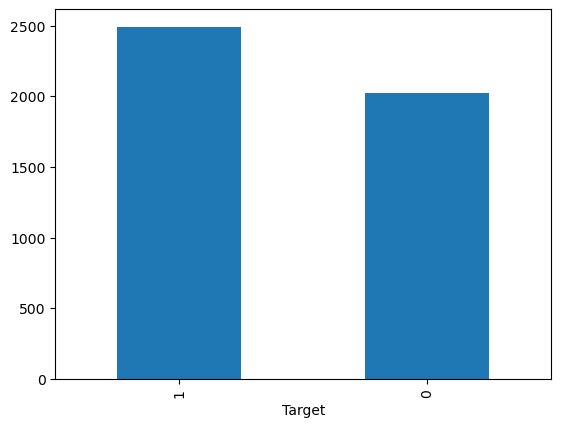

In [908]:
df['Target'].value_counts().plot(kind='bar')

In [909]:
# Price-based Features
# Daily Returns:
# Calculate percentage change in Adj Close prices.
df['Daily_Return'] = df['Adj Close'].pct_change()


grouped = df.groupby('Company')

# Add Moving Average, Upper, and Lower Boundaries
window_size=14
std_multiplier=2
df['Moving Average'] = grouped['Close'].transform(lambda x: x.rolling(window=window_size).mean())
df['Rolling Std'] = grouped['Close'].transform(lambda x: x.rolling(window=window_size).std())
df['Upper Boundary'] = df['Moving Average'] + (std_multiplier * df['Rolling Std'])
df['Lower Boundary'] = df['Moving Average'] - (std_multiplier * df['Rolling Std'])
df['Log Return'] = np.log(df['Close'] / df['Close'].shift(1))
df['Moving Average Log Return'] = grouped['Log Return'].transform(lambda x: x.rolling(window=window_size).mean())
df['EMA_30'] = grouped['Close'].transform(lambda x: x.ewm(span=30, adjust=False).mean())


#  Price-based Features
# Daily Returns:
# Calculate percentage change in Adj Close price

# Rolling Statistics:
# Compute rolling mean, standard deviation, and volatility over different windows (e.g., 7, 14, 30 days)


df['Rolling_Mean_7'] = df['Adj Close'].rolling(window=7).mean()
df['Rolling_Std_7'] = df['Adj Close'].rolling(window=7).std()
df['Rolling_Mean_14'] = df['Adj Close'].rolling(window=14).mean()
df['Rolling_Std_14'] = df['Adj Close'].rolling(window=14).std()
df['Rolling_Mean_30'] = df['Adj Close'].rolling(window=30).mean()
df['Rolling_Std_30'] = df['Adj Close'].rolling(window=30).std()


# Momentum Indicators:
# Example: Relative Strength Index (RSI)
def compute_rsi(data, window=14):
    delta = data.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = compute_rsi(df['Adj Close'])

# Volume-based Features
# Volume Rolling Stats:
# Rolling mean and standard deviation of volume.

df['Volume_Rolling_Mean_7'] = df['Volume'].rolling(window=7).mean()
df['Volume_Rolling_Std_7'] = df['Volume'].rolling(window=7).std()

df['Volume_Rolling_Mean_14'] = df['Volume'].rolling(window=14).mean()
df['Volume_Rolling_Std_14'] = df['Volume'].rolling(window=14).std()

df['Volume_Rolling_Mean_30'] = df['Volume'].rolling(window=30).mean()
df['Volume_Rolling_Std_30'] = df['Volume'].rolling(window=30).std()

# Lagged Features
# Include lagged values of Adj Close and Volume to capture short-term trends.

for lag in [1, 2,3, 5,7, 10,14]:
    df[f'Lag_{lag}'] = df['Adj Close'].shift(lag)

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Company_Encoded'] = le.fit_transform(df['Company'])


# Moving Average Convergence Divergence (MACD)
# Purpose: Tracks the relationship between two moving averages of a stock's price.

df['EMA_12'] = df['Adj Close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['Adj Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA_12'] - df['EMA_26']
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

df['14_high'] = df['High'].rolling(window=14).max()
df['14_low'] = df['Low'].rolling(window=14).min()
df['7_high'] = df['High'].rolling(window=7).max()
df['7_low'] = df['Low'].rolling(window=7).min()
df['2_high'] = df['High'].rolling(window=2).max()
df['2_low'] = df['Low'].rolling(window=2).min()


df['%K'] = (df['Close'] - df['14_low']) / (df['14_high'] - df['14_low']) * 100
df['%D'] = df['%K'].rolling(window=3).mean()

df['%R'] = (df['14_high'] - df['Close']) / (df['14_high'] - df['14_low']) * -100



df['ROC'] = df['Adj Close'].pct_change(periods=10) * 100


df['TR'] = df[['High', 'Low', 'Close']].apply(
    lambda x: max(x['High'] - x['Low'], abs(x['High'] - x['Close']), abs(x['Low'] - x['Close'])), axis=1)
df['ATR'] = df['TR'].rolling(window=14).mean()


df['Typical_Price'] = (df['High'] + df['Low'] + df['Close']) / 3
df['CCI'] = (df['Typical_Price'] - df['Typical_Price'].rolling(window=20).mean()) / (0.015 * df['Typical_Price'].rolling(window=20).std())


df['MA_7'] = df['Close'].rolling(window=7).mean()
df['MA_14'] = df['Close'].rolling(window=14).mean()
df['MA_30'] = df['Close'].rolling(window=30).mean()


df['Disparity_7'] = (df['Close'] / df['MA_7'] - 1) * 100
df['Disparity_14'] = (df['Close'] / df['MA_14'] - 1) * 100
df['Disparity_30'] = (df['Close'] / df['MA_30'] - 1) * 100



df = df.copy()

# df['Company_ID'] = df['Company'].astype('category').cat.codes

if 'Date' in df.columns:
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek  # Optional: Add the day of the week as a feature
    df['IsWeekend'] = (df['DayOfWeek'] >= 5).astype(int)  # Optional: Feature for weekends (1 if weekend, 0 otherwise)
    df.drop(columns=['Date'], inplace=True)  # Drop the original 'Date' column




#RSI IS .4% MI, AND IT TAKES ABOUT 1000+ ROWS AS NULL SO IM REMOVING
# similarly %K,D,R
del df['RSI']
del df['%K']
del df['%D']
del df['%R']

In [910]:
df1=df.copy()#for reference

In [911]:

df_eval = df[['Company', 'Target']]


In [912]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4512 entries, 1108 to 43195
Data columns (total 62 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Adj Close                  4512 non-null   float64
 1   Close                      4512 non-null   float64
 2   High                       4512 non-null   float64
 3   Low                        4512 non-null   float64
 4   Open                       4512 non-null   float64
 5   Volume                     4512 non-null   int64  
 6   Company                    4512 non-null   object 
 7   Target                     4512 non-null   int32  
 8   Daily_Return               4511 non-null   float64
 9   Moving Average             4044 non-null   float64
 10  Rolling Std                4044 non-null   float64
 11  Upper Boundary             4044 non-null   float64
 12  Lower Boundary             4044 non-null   float64
 13  Log Return                 4511 non-null   float6

<Axes: >

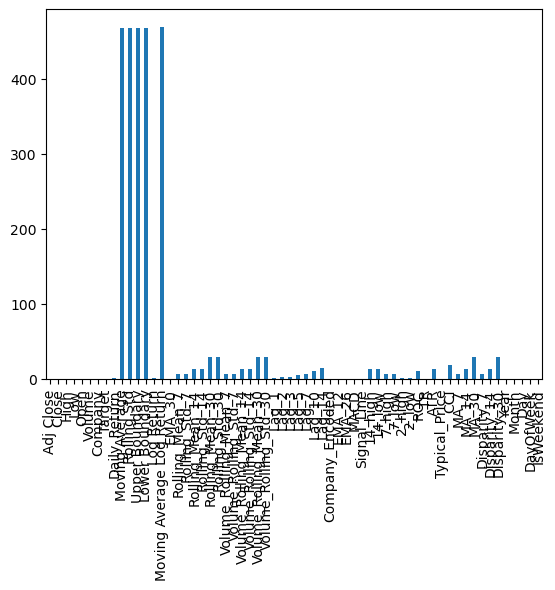

In [913]:
df.isnull().sum().plot(kind='bar')

In [914]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)


In [915]:
df_eval = df[['Company', 'Target']]


In [916]:
print(a)

NameError: name 'a' is not defined

In [919]:
X = df[selected_features]

y=df['Target']
# X=df[['14_high', '14_low', '7_low', '7_high', '2_high', '2_low',
#        'Upper Boundary', 'Lower Boundary', 'EMA_30', 'EMA_26', 'MA_7',
#        'Rolling_Mean_30', 'MA_30', 'Adj Close', 'Rolling_Mean_14', 'MA_14',
#        'Rolling_Mean_7', 'Moving Average', 'EMA_12', 'Typical_Price', 'Lag_1',
#        'Lag_2', 'Lag_3', 'Close', 'High', 'Volume_Rolling_Std_30', 'Lag_5',
#        'Lag_7', 'Low', 'Open', 'Lag_14', 'Lag_10', 'Volume_Rolling_Mean_14',
#        'Volume_Rolling_Mean_30', 'Month', 'Volume_Rolling_Std_14']]

X_test = scaler.transform(X)

X_test

array([[-0.81368278, -0.80578071, -0.8120966 , ..., -0.42400286,
        -0.43204642, -0.43570527],
       [-0.81243144, -0.80578071, -0.81083087, ..., -0.42523597,
        -0.43198215, -0.4399077 ],
       [-0.8120021 , -0.80578071, -0.8103966 , ..., -0.4248795 ,
        -0.43217056, -0.43995482],
       ...,
       [-0.70252797, -0.69658711, -0.69966371, ...,  0.22956758,
         0.30698832, -0.04796058],
       [-0.70252797, -0.69658711, -0.69966371, ...,  0.20512768,
         0.29227782, -0.06507239],
       [-0.70252797, -0.69658711, -0.69966371, ...,  0.19409531,
         0.28619409, -0.03819888]])

In [921]:
X_test.shape

(4028, 35)

In [ ]:
# from joblib import load

# # Load the models
# loaded_models = load("best_models.joblib")


In [923]:
import pandas as pd

if isinstance(X_train, np.ndarray):  
    X_train = pd.DataFrame(X_train, columns=selected_features)  # Use the correct feature names

if isinstance(X_test, np.ndarray):  
    X_test = pd.DataFrame(X_test, columns=selected_features)  # Ensure same feature names


In [925]:
print("Train features:", X_train.columns.tolist())
print("Test features:", X_test.columns.tolist())


Train features: ['14_high', '14_low', '7_high', '7_low', '2_high', '2_low', 'Upper Boundary', 'Lower Boundary', 'EMA_30', 'EMA_26', 'MA_7', 'Rolling_Mean_30', 'MA_30', 'Adj Close', 'Rolling_Mean_14', 'MA_14', 'Rolling_Mean_7', 'Moving Average', 'EMA_12', 'Typical_Price', 'Lag_1', 'Lag_3', 'Lag_2', 'Close', 'Lag_5', 'Volume_Rolling_Std_30', 'High', 'Low', 'Lag_7', 'Lag_14', 'Open', 'Lag_10', 'Volume_Rolling_Mean_14', 'Volume_Rolling_Mean_30', 'Volume_Rolling_Std_14']
Test features: ['14_high', '14_low', '7_high', '7_low', '2_high', '2_low', 'Upper Boundary', 'Lower Boundary', 'EMA_30', 'EMA_26', 'MA_7', 'Rolling_Mean_30', 'MA_30', 'Adj Close', 'Rolling_Mean_14', 'MA_14', 'Rolling_Mean_7', 'Moving Average', 'EMA_12', 'Typical_Price', 'Lag_1', 'Lag_3', 'Lag_2', 'Close', 'Lag_5', 'Volume_Rolling_Std_30', 'High', 'Low', 'Lag_7', 'Lag_14', 'Open', 'Lag_10', 'Volume_Rolling_Mean_14', 'Volume_Rolling_Mean_30', 'Volume_Rolling_Std_14']


In [927]:
print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (30034, 35)
Test shape: (4028, 35)


In [929]:
results = {}
for name, model in best_models.items():
    # Train the model
    # model.fit(X_train, y_train)
    
    # Make predictions
    
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None
    
    # Evaluate the model
    results[name] = evaluate_model(y, y_pred, y_prob)

C:\Users\hp\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


In [931]:

results_df = pd.DataFrame(results).T
results_df

,Accuracy,Precision,Recall (Sensitivity),F1-Score,Specificity,ROC AUC
Logistic Regression,0.574230,0.608721,0.501197,0.549751,0.652914,0.561426
Random Forest,0.536246,0.544324,0.649593,0.592318,0.414131,0.525987
XGBoost,0.584409,0.581404,0.709430,0.639069,0.449716,0.579461


C:\Users\hp\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\hp\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


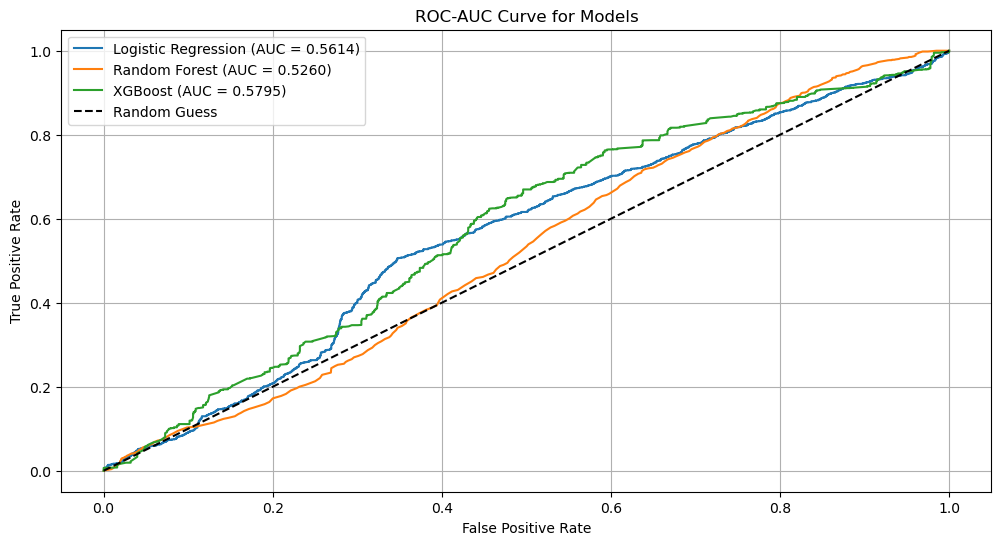

In [933]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score

plt.figure(figsize=(12, 6))

# Loop through each model and plot its ROC curve
for name, model in best_models.items():
    if hasattr(model, "predict_proba"):
        
        y_prob = model.predict_proba(X_test)[:, 1]
        
        # Compute ROC curve and AUC
        fpr, tpr, _ = roc_curve(y, y_prob)
        roc_auc = auc(fpr, tpr)
        
        plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.4f})")
    else:
        print(f"Skipping {name}: No probability predictions available.")

# Plot the diagonal reference line (chance level)
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-AUC Curve for Models")
plt.legend()
plt.grid()
plt.show()


In [935]:
df_results = df_eval.copy()
df_results['Predicted'] = y_pred

# Option 1: Simple evaluation per company (Correct count, Wrong count, Accuracy)
company_results_simple = df_results.groupby('Company').apply(
    lambda grp: pd.Series({
        'Correct': (grp['Target'] == grp['Predicted']).sum(),
        'Wrong': (grp['Target'] != grp['Predicted']).sum(),
        'Accuracy': (grp['Target'] == grp['Predicted']).mean()
    })
).reset_index()

print("Company-level evaluation (simple):")
print(company_results_simple)


Company-level evaluation (simple):
          Company  Correct  Wrong  Accuracy
0             ACA     73.0   27.0  0.730000
1     ADANIENT.NS     65.0   49.0  0.570175
2   ASIANPAINT.NS     91.0   23.0  0.798246
3   BAJFINANCE.NS     86.0   28.0  0.754386
4   BHARTIARTL.NS     58.0   56.0  0.508772
5        CIPLA.NS     46.0   68.0  0.403509
6    COALINDIA.NS     53.0   61.0  0.464912
7      DRREDDY.NS     57.0   57.0  0.500000
8    EICHERMOT.NS     43.0   71.0  0.377193
9       GRASIM.NS     42.0   72.0  0.368421
10     HCLTECH.NS     77.0   37.0  0.675439
11    HDFCBANK.NS     49.0   65.0  0.429825
12  HINDUNILVR.NS     56.0   58.0  0.491228
13   ICICIBANK.NS     85.0   29.0  0.745614
14  INDUSINDBK.NS     64.0   50.0  0.561404
15        INFY.NS     80.0   34.0  0.701754
16         ITC.NS     61.0   53.0  0.535088
17   KOTAKBANK.NS     73.0   41.0  0.640351
18          LT.NS     77.0   37.0  0.675439
19         M&M.NS     68.0   46.0  0.596491
20      MARUTI.NS     74.0   40.0  0.6491

C:\Users\hp\AppData\Local\Temp\ipykernel_6732\3222334176.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  company_results_simple = df_results.groupby('Company').apply(


In [939]:

company_results = df_results.groupby('Company').apply(
    lambda grp: pd.Series({
        'Total_Target_1': (grp['Target'] == 1).sum(),
        'Total_Target_0': (grp['Target'] == 0).sum(),
        'Correctly_Predicted_Target_1': ((grp['Target'] == 1) & (grp['Predicted'] == 1)).sum(),
        'Incorrectly_Predicted_Target_1': ((grp['Target'] == 1) & (grp['Predicted'] != 1)).sum(),
        'Correctly_Predicted_Target_0': ((grp['Target'] == 0) & (grp['Predicted'] == 0)).sum(),
        'Incorrectly_Predicted_Target_0': ((grp['Target'] == 0) & (grp['Predicted'] != 0)).sum()
    })
).reset_index()

print("Detailed company-level evaluation:")
company_results


Detailed company-level evaluation:


C:\Users\hp\AppData\Local\Temp\ipykernel_6732\2314164773.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  company_results = df_results.groupby('Company').apply(


,Company,Total_Target_1,Total_Target_0,Correctly_Predicted_Target_1,Incorrectly_Predicted_Target_1,Correctly_Predicted_Target_0,Incorrectly_Predicted_Target_0
0,ACA,90,10,73,17,0,10
1,ADANIENT.NS,42,72,22,20,43,29
2,ASIANPAINT.NS,74,40,51,23,40,0
3,BAJFINANCE.NS,32,82,32,0,54,28
4,BHARTIARTL.NS,62,52,40,22,18,34
5,CIPLA.NS,46,68,46,0,0,68
6,COALINDIA.NS,58,56,53,5,0,56
7,DRREDDY.NS,57,57,57,0,0,57
8,EICHERMOT.NS,48,66,37,11,6,60
9,GRASIM.NS,32,82,8,24,34,48


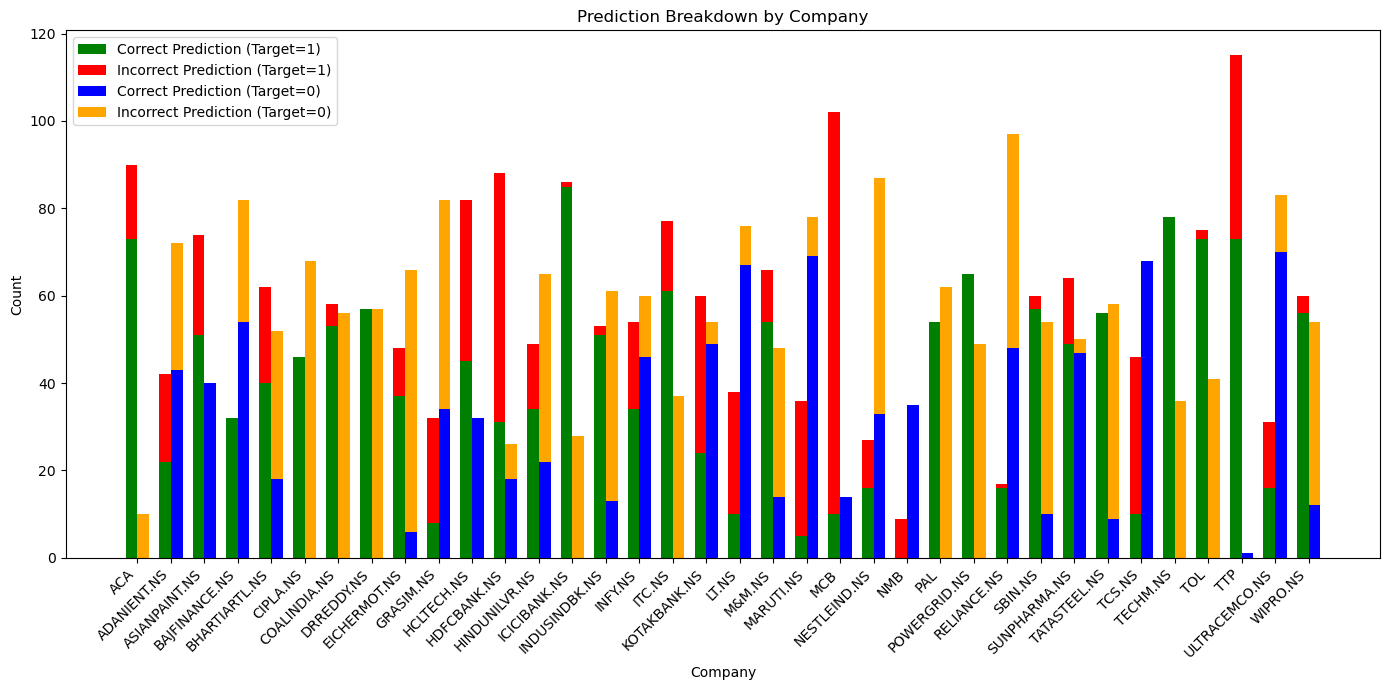

In [941]:

# For plotting, we use the detailed counts from the previous step.
companies = company_results['Company']
x = np.arange(len(companies))
width = 0.35  # Width of each bar group

# Extract counts for Target=1 predictions (left bars) and Target=0 predictions (right bars)
correct_target_1 = company_results['Correctly_Predicted_Target_1']
incorrect_target_1 = company_results['Incorrectly_Predicted_Target_1']
correct_target_0 = company_results['Correctly_Predicted_Target_0']
incorrect_target_0 = company_results['Incorrectly_Predicted_Target_0']

fig, ax = plt.subplots(figsize=(14, 7))

# Plot bars for Target=1 predictions (positioned at x - width/2)
bar1 = ax.bar(x - width/2, correct_target_1, width, 
              label='Correct Prediction (Target=1)', color='green')
bar2 = ax.bar(x - width/2, incorrect_target_1, width, 
              bottom=correct_target_1, label='Incorrect Prediction (Target=1)', color='red')

# Plot bars for Target=0 predictions (positioned at x + width/2)
bar3 = ax.bar(x + width/2, correct_target_0, width, 
              label='Correct Prediction (Target=0)', color='blue')
bar4 = ax.bar(x + width/2, incorrect_target_0, width, 
              bottom=correct_target_0, label='Incorrect Prediction (Target=0)', color='orange')

ax.set_xticks(x)
ax.set_xticklabels(companies, rotation=45, ha='right')
ax.set_xlabel('Company')
ax.set_ylabel('Count')
ax.set_title('Prediction Breakdown by Company')
ax.legend()
plt.tight_layout()
plt.show()